<a href="https://colab.research.google.com/github/ahmed27kar/CallableBond_Valuation_Model/blob/main/Data_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

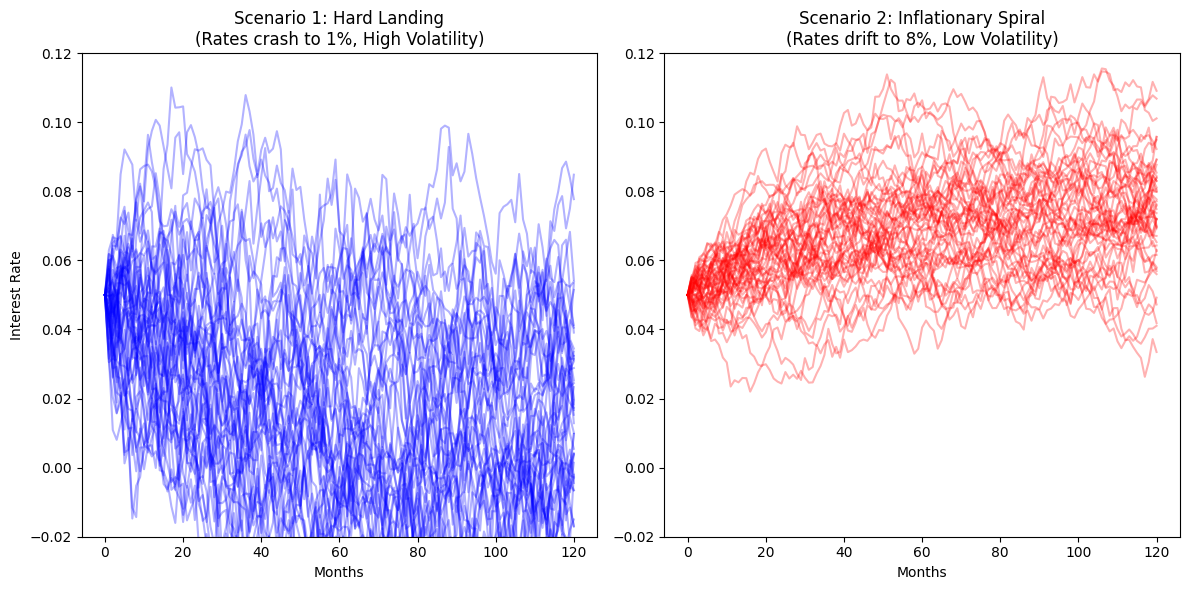

Data generated and CSV files saved!


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. CONFIGURATION ---
# Simulation settings
num_paths = 1000       # We will simulate 1000 different futures
time_years = 10        # 10-year bond
steps_per_year = 12    # Monthly steps
dt = 1/steps_per_year  # Time step size
T = int(time_years * steps_per_year) # Total steps (120)

# --- 2. THE AI-ASSISTED VASICEK FUNCTION ---
def generate_paths(r0, kappa, theta, sigma, num_paths, T, dt):
    # Create a matrix to hold the rates: [Time Steps x Number of Paths]
    rates = np.zeros((T + 1, num_paths))
    rates[0] = r0

    # Loop through each time step
    for t in range(1, T + 1):
        # Generate random shocks (Z) from a normal distribution
        Z = np.random.normal(0, 1, num_paths)

        # Current rate
        r_prev = rates[t-1]

        # The Vasicek Formula:
        # New Rate = Old Rate + (Speed * Gap to Target) + (Volatility * Shock)
        dr = kappa * (theta - r_prev) * dt + sigma * np.sqrt(dt) * Z

        rates[t] = r_prev + dr

    return rates

# --- 3. DEFINING YOUR TWO SCENARIOS ---

# Scenario 1: "The Hard Landing"
# Starts at 5%, crashes down to 1% long-term, high volatility (3%)
rates_hard_landing = generate_paths(
    r0=0.05,    # Starting Interest Rate (5%)
    kappa=0.5,  # Speed of reversion
    theta=0.01, # Long-term target (1%)
    sigma=0.03, # High Volatility (3%)
    num_paths=num_paths, T=T, dt=dt
)

# Scenario 2: "The Inflationary Spiral"
# Starts at 5%, drifts up to 8% long-term, low volatility (1%)
rates_inflation = generate_paths(
    r0=0.05,    # Starting Interest Rate (5%)
    kappa=0.2,  # Slow speed
    theta=0.08, # Long-term target (8%)
    sigma=0.01, # Low Volatility (1%)
    num_paths=num_paths, T=T, dt=dt
)

# --- 4. VISUALIZATION (To prove it works) ---
plt.figure(figsize=(12, 6))

# Plot Scenario 1
plt.subplot(1, 2, 1)
plt.plot(rates_hard_landing[:, :50], alpha=0.3, color='blue') # Plotting first 50 paths
plt.title('Scenario 1: Hard Landing\n(Rates crash to 1%, High Volatility)')
plt.xlabel('Months')
plt.ylabel('Interest Rate')
plt.ylim(-0.02, 0.12) # Fix y-axis to compare easily

# Plot Scenario 2
plt.subplot(1, 2, 2)
plt.plot(rates_inflation[:, :50], alpha=0.3, color='red')
plt.title('Scenario 2: Inflationary Spiral\n(Rates drift to 8%, Low Volatility)')
plt.xlabel('Months')
plt.ylim(-0.02, 0.12)

plt.tight_layout()
plt.show()

# --- 5. EXPORT TO CSV (For GitHub) ---
# We save the average path and a few sample paths to upload to GitHub
df_scenario1 = pd.DataFrame(rates_hard_landing)
df_scenario2 = pd.DataFrame(rates_inflation)

df_scenario1.to_csv('scenario_1_hard_landing.csv', index=False)
df_scenario2.to_csv('scenario_2_inflation.csv', index=False)

print("Data generated and CSV files saved!")

In [2]:
# --- 1. PRICING CONFIGURATION ---
FACE_VALUE = 1000
COUPON_RATE = 0.05
COUPON = FACE_VALUE * COUPON_RATE
YEARS = 10
CALL_PRICE = 1000
CALLABLE_AFTER_YEAR = 5

# Map years to time steps in our model
call_start_step = CALLABLE_AFTER_YEAR * steps_per_year
total_steps = YEARS * steps_per_year

# --- 2. THE PRICING ENGINE (Backward Induction) ---
def price_callable_bond(rate_paths):
    # Initialize a matrix to hold bond values at every step
    # Shape: [Time Steps x Num Paths]
    bond_values = np.zeros_like(rate_paths)

    # Set value at maturity (Year 10) = Face Value
    bond_values[-1, :] = FACE_VALUE

    # Loop BACKWARDS from the end to the beginning
    for t in range(total_steps - 1, -1, -1):
        # 1. Calculate discount factor for this small time step
        r_t = rate_paths[t, :]  # Rates at this moment
        df = np.exp(-r_t * dt)

        # 2. Value = (Value tomorrow + Coupon if paid) * Discount
        # Note: We simplify and add coupons continuously or at year end.
        # For this model, we assume continuous coupon flow for smoother math
        cash_flow = bond_values[t+1, :]

        # Add coupon payment if we hit a year-end marker
        if (t + 1) % steps_per_year == 0:
            cash_flow += COUPON

        value_uncallable = cash_flow * df

        # 3. CHECK FOR CALL OPTION
        # If we are past Year 5 (call_start_step), check the rule
        if t >= call_start_step:
            # If Value > 1000, Issuer calls it at 1000.
            # We take the MINIMUM of (Calculated Value, 1000)
            bond_values[t, :] = np.minimum(value_uncallable, CALL_PRICE)
        else:
            # Before Year 5, it cannot be called.
            bond_values[t, :] = value_uncallable

    # The price today is the average of all 1000 simulations at Time 0
    return np.mean(bond_values[0, :])

# --- 3. RUNNING THE MODEL ---
price_hard_landing = price_callable_bond(rates_hard_landing)
price_inflation = price_callable_bond(rates_inflation)

# --- 4. PRINTING THE RESULTS ---
print(f"--- FINAL VALUATION RESULTS ---")
print(f"Scenario 1 (Hard Landing/Rates Drop): ${price_hard_landing:.2f}")
print(f"Scenario 2 (Inflation/Rates Rise):    ${price_inflation:.2f}")

print("\n--- ANALYSIS ---")
if price_hard_landing < 1100: # Heuristic check
    print("Notice in Scenario 1: Even though rates dropped (which usually boosts prices),")
    print("the price didn't explode upwards. The 'Call Option' capped the value near $1,000.")

--- FINAL VALUATION RESULTS ---
Scenario 1 (Hard Landing/Rates Drop): $1096.50
Scenario 2 (Inflation/Rates Rise):    $851.58

--- ANALYSIS ---
Notice in Scenario 1: Even though rates dropped (which usually boosts prices),
the price didn't explode upwards. The 'Call Option' capped the value near $1,000.
